In [1]:
import cv2
import numpy as np
import mediapipe as mp
import matplotlib.pyplot as plt

import seaborn as sns
import networkx as nx
import pickle

Changing video path will change paths in entire code

In [15]:

input_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/Squats/Videos/actual/correct-squat-side-view (online-video-cutter.com).mp4'
output_folder = '/Users/suryanshpatel/Projects/Pose_detection/Frames/annotated_frames/af6'
coordinates_folder = '/Users/suryanshpatel/Projects/Pose_detection/Frames/plots/co6'
output_video_path = '/Users/suryanshpatel/Projects/Pose_detection/videos/pose_detection_yolo.mp4'

Load YOLO Model

In [10]:
net = cv2.dnn.readNet('/Users/suryanshpatel/Projects/Pose_detection/yolo/yolov3.weights', '/Users/suryanshpatel/Projects/Pose_detection/yolo/yolov3.cfg')
layer_names = net.getLayerNames()

# Adjust indexing to handle both cases where net.getUnconnectedOutLayers() returns a 1D or 2D array
try:
    output_layers = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]
except IndexError:
    output_layers = [layer_names[i - 1] for i in net.getUnconnectedOutLayers()]

Load Medipipe Poses for detection

In [11]:
# Initialize MediaPipe Pose
mp_drawing = mp.solutions.drawing_utils
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

I0000 00:00:1718864293.954894 5239358 gl_context.cc:357] GL version: 2.1 (2.1 Metal - 88.1), renderer: Apple M2


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.
W0000 00:00:1718864294.046200 5244945 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1718864294.057686 5244946 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Structure in which we are capturing the data

In [12]:
class PoseLandmark:
    def __init__(self, x, y, visibility, box_dimensions):
        self._x = x
        self._y = y
        # self._z = z
        self._visibility = visibility
        self._box_dimensions = box_dimensions  # New field

    # Getters
    def get_x(self):
        return self._x

    def get_y(self):
        return self._y

    # def get_z(self):
    #     return self._z

    def get_visibility(self):
        return self._visibility

    def get_box_dimensions(self):
        return self._box_dimensions

    # Setters
    def set_x(self, x):
        self._x = x

    def set_y(self, y):
        self._y = y

    # def set_z(self, z):
    #     self._z = z

    def set_visibility(self, visibility):
        self._visibility = visibility

    def set_box_dimensions(self, box_dimensions):
        self._box_dimensions = box_dimensions

    # __str__ method for string representation
    def __str__(self):
        return (f"PoseLandmark(x={self._x}, y={self._y},  " #z={self._z} ,
                f"visibility={self._visibility}, box_dimensions={self._box_dimensions})")

    # Normalize joint coordinates based on bounding box dimensions
    def normalize(self):
        x, y, w, h = self._box_dimensions
        norm_x = (self._x - x) / w if w != 0 else 0
        norm_y = (self._y - y) / h if h != 0 else 0
        return PoseLandmark(norm_x, norm_y,  self._visibility, (0, 0, 1, 1))  # normalized box is (0,0,1,1)



Main driver Code

In [16]:
# Function to process a video and extract joint points and bounding box dimensions
def process_video(input_video_path, output_video_path, net, output_layers, pose):
    cap = cv2.VideoCapture(input_video_path)
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(cap.get(cv2.CAP_PROP_FPS))

    # Initialize VideoWriter
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for mp4 files
    # output = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))


    all_frame_data = []

    while cap.isOpened():
        success, frame = cap.read()
        if not success:
            break

        height, width, channels = frame.shape
        blob = cv2.dnn.blobFromImage(frame, 0.00392, (416, 416), (0, 0, 0), True, crop=False)
        net.setInput(blob)
        outs = net.forward(output_layers)

        # Track the best detection
        best_confidence = 0
        best_box = None

        # Get bounding box for the person with the highest confidence
        for out in outs:
            for detection in out:
                scores = detection[5:]
                class_id = np.argmax(scores)
                confidence = scores[class_id]
                if class_id == 0 and confidence > best_confidence:  # Class 0 is for person
                    best_confidence = confidence
                    center_x = int(detection[0] * width)
                    center_y = int(detection[1] * height)
                    w = int(detection[2] * width)
                    h = int(detection[3] * height)
                    x = max(0, int(center_x - w / 2))
                    y = max(0, int(center_y - h / 2))
                    w = min(w, width - x)
                    h = min(h, height - y)
                    best_box = (x, y, w, h)

        if best_box:
            x, y, w, h = best_box

            # Extract the region within the bounding box
            roi = frame[y:y+h, x:x+w]

            if roi.size == 0:  # Check if the ROI is empty
                continue

            # Process the region with MediaPipe for pose estimation
            rgb_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
            results = pose.process(rgb_frame)

            # Capture joint points
            single_frame_data = []
            if results.pose_landmarks:
                for landmark in results.pose_landmarks.landmark:
                    single_frame_data.append(PoseLandmark(landmark.x * w + x , landmark.y * h + y , landmark.visibility ,(x, y, w, h)))
                   
            #Surya - don't want to normalize now store as it is as we are storing box dimentions as well
            #  Normalize joint points within bounding box
            # normalized_points = normalize_joint_points_within_box(joint_points, (x, y, w, h))
            # all_joint_points.append(normalized_points)
        

            # Check if the number of joints detected is consistent
            if len(single_frame_data) == 33:  # Adjust 33 to your actual expected number of joints
                all_frame_data.append(single_frame_data)
            else:
                print(f"Skipping frame {len(all_frame_data) + 1} due to incomplete data: {len(single_frame_data)} joints")

            # Draw the bounding box
            cv2.rectangle(frame, (x, y), (x + w, y + h), (0, 255, 0), 2)

            # Draw the pose annotation on the image
            if results.pose_landmarks:
                mp.solutions.drawing_utils.draw_landmarks(roi, results.pose_landmarks, mp.solutions.pose.POSE_CONNECTIONS)

        # Write the frame to the output video
        # output.write(frame)

        # Optionally display the image
        cv2.imshow('Pose Detection', frame)
        if cv2.waitKey(5) & 0xFF == 27:  # Press 'Esc' to exit
            break

    # Release resources
    cap.release()
    # output.release()
    cv2.destroyAllWindows()

    # Convert lists to NumPy arrays
    all_frame_data = np.array(all_frame_data, dtype=object)


    return all_frame_data


# Normalizes each frame data based on bounding box instead of frame
def normalize_frame_data(frame_data):
    normalized_data = []
    for frame in frame_data:
        normalized_frame = [landmark.normalize() for landmark in frame]
        normalized_data.append(normalized_frame)
    return np.array(normalized_data, dtype=object)



# Process the video
all_frame_data = process_video(input_video_path, output_video_path, net, output_layers, pose)

# Normalize the extracted data
normalized_data = normalize_frame_data(all_frame_data)

# Print shapes of extracted and normalized data
print("All frames object dimensions:", all_frame_data.shape)
print("Normalized frames object dimensions:", normalized_data.shape)


/Users/suryanshpatel/Projects/Pose_detection/.venv/lib/python3.12/site-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


All frames object dimensions: (88, 33)
Normalized frames object dimensions: (88, 33)


save coodinates

In [17]:
# np.save('/Users/suryanshpatel/Projects/Pose_detection/npArrays/incorrect_squats.npy' , normalized_data)
# incorrect_squats = normalized_data.copy()
correct_squats = normalized_data.copy()


plot 2 exercise coodinates against each other

In [18]:
'''
change last 2 lines to alter data points for x,y extraction
'''
def extract_coordinates(pose_data):
    num_frames = len(pose_data)
    num_joints = len(pose_data[0])
    
    # Initialize an empty array to hold the coordinates
    coordinates = np.zeros((num_frames, num_joints, 2))
    
    for i, frame in enumerate(pose_data):
        for j, landmark in enumerate(frame):
            coordinates[i, j, 0] = landmark.get_x()
            coordinates[i, j, 1] = landmark.get_y()
    
    return coordinates

# Example usage
# Assuming pose_data_video1 and pose_data_video2 are lists of lists of PoseLandmark instances
coordinates_video1 = extract_coordinates(correct_squats)
coordinates_video2 = extract_coordinates(incorrect_squats)


In [ ]:
# Plot based on above extract values
def plot_joint_movements_side_by_side(normalized_data1, normalized_data2, title1, title2):
    num_joints = normalized_data1.shape[1]  # Number of joints
    num_frames1 = normalized_data1.shape[0]
    num_frames2 = normalized_data2.shape[0]
    
    plt.figure(figsize=(20, 10))
    
    for i in range(num_joints):
        plt.subplot(6, 6, i + 1)  # Assuming there are at most 36 joints for a 6x6 grid

        # Plot for video 1
        plt.plot(range(num_frames1), normalized_data1[:, i], 'b-', label=title1 if i == 0 else "")
        
        # Plot for video 2
        plt.plot(range(num_frames2), normalized_data2[:, i], 'r-', label=title2 if i == 0 else "")
        
        plt.title(f'Joint {i + 1}')
        plt.xlabel('Frame')
        plt.ylabel('Value')
        
    plt.suptitle(f'Joint Movements: {title1} (Blue) vs {title2} (Red)', fontsize=16)
    plt.legend(loc='upper right')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


# Example usage
plot_joint_movements_side_by_side(coordinates_video1, coordinates_video2, "corrrect", "incorrect")


Compare actual data v/s normalized data

Compare some values from the original and normalized arrays.

:param original_data: List of lists of PoseLandmark objects (original data).
:param normalized_data: List of lists of PoseLandmark objects (normalized data).
:param num_samples: Number of samples to compare from each array.


In [ ]:
def compare_landmark_values(original_data, normalized_data, num_samples=5):
 
    num_frames = min(len(original_data), len(normalized_data))

    print("Comparing some values from the original and normalized data:")
    for i in range(min(num_samples, num_frames)):
        print(f"\nFrame {i + 1}:")
        original_frame = original_data[i]
        normalized_frame = normalized_data[i]
        
        num_landmarks = min(len(original_frame), len(normalized_frame))
        for j in range(min(num_samples, num_landmarks)):
            original_landmark = original_frame[j]
            normalized_landmark = normalized_frame[j]

            print(f"  Landmark {j + 1}:")
            print(f"    Original: x={original_landmark.get_x()}, y={original_landmark.get_y()}, "
                  f"visibility={original_landmark.get_visibility()}")
            print(f"    Normalized: x={normalized_landmark.get_x()}, y={normalized_landmark.get_y()}, "
                  f"visibility={normalized_landmark.get_visibility()}")


# Example usage
compare_landmark_values(all_frame_data, normalized_data, num_samples=5)


Plots for each joints

plot every joint and print trejectory for individual exercise

In [ ]:


# Example function to extract data from all_frame_data
def extract_joint_data(all_frame_data):
    num_frames = all_frame_data.shape[0]
    num_joints = len(all_frame_data[0])  # Assuming all frames have the same number of joints
    
    # Initialize lists to store joint coordinates across frames
    joint_x = [[] for _ in range(num_joints)]
    joint_y = [[] for _ in range(num_joints)]
    
    # Iterate through each frame and each joint to extract coordinates
    for frame_idx in range(num_frames):
        frame = all_frame_data[frame_idx]
        for joint_idx in range(num_joints):
            landmark = frame[joint_idx]
            joint_x[joint_idx].append(landmark.get_x())  # Replace with actual method to get x coordinate
            joint_y[joint_idx].append(landmark.get_y())  # Replace with actual method to get y coordinate
    
    # Convert lists to NumPy arrays for plotting convenience
    joint_x = np.array(joint_x)
    joint_y = np.array(joint_y)
    
    return joint_x, joint_y

# Example usage
joint_x, joint_y = extract_joint_data(normalized_data)

# Plotting pair plot for all joints with arrows between consecutive frames
num_joints = joint_x.shape[0]
plt.figure(figsize=(15, 15))
for i in range(num_joints):
    plt.subplot(6, 6, i + 1)
    
    # Scatter plot with arrows between consecutive frames
    sns.scatterplot(x=joint_x[i], y=joint_y[i], marker='o', s=10)
    for j in range(len(joint_x[i]) - 1):
        dx = joint_x[i][j + 1] - joint_x[i][j]
        dy = joint_y[i][j + 1] - joint_y[i][j]
        plt.arrow(joint_x[i][j], joint_y[i][j], dx * 0.8, dy * 0.8, color='r', head_width=0.002, head_length=0.004)
    
    plt.title(f'Joint {i + 1}')
    plt.xlabel('X coordinate')
    plt.ylabel('Y coordinate')
plt.tight_layout()
plt.show()


Generate GNN's for this exercise and save for future analysis

In [35]:
edges = [
    (0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), # Head
    (9, 10), # Mouth
    (11, 12), # Shoulders
    (11, 13), (13, 15), (15, 17), (15, 19), (15, 21), # Left arm
    (12, 14), (14, 16), (16, 18), (16, 20), (16, 22), # Right arm
    (11, 23), (12, 24), # Torso
    (23, 25), (25, 27), (27, 29), (27, 31), # Left leg
    (24, 26), (26, 28), (28, 30), (28, 32)  # Right leg
]


In [36]:
def create_graph_from_joint_points(joint_points, edges):
    G = nx.Graph()
    
    # Add nodes with positions
    for i, (x, y) in enumerate(joint_points):
        G.add_node(i, pos=(x, y))
    
    # Add edges based on the body structure
    G.add_edges_from(edges)
    
    return G

# Function to convert a sequence of joint points frames into a list of graphs
def create_graphs_from_video(joint_points_sequence, edges):
    graphs = []
    for frame in joint_points_sequence:
        graph = create_graph_from_joint_points(frame, edges)
        graphs.append(graph)
    return graphs

# Example usage
graphs_video1 = create_graphs_from_video(coordinates_video1, edges)
graphs_video2 = create_graphs_from_video(coordinates_video2, edges)


Corrected Graph visulizations

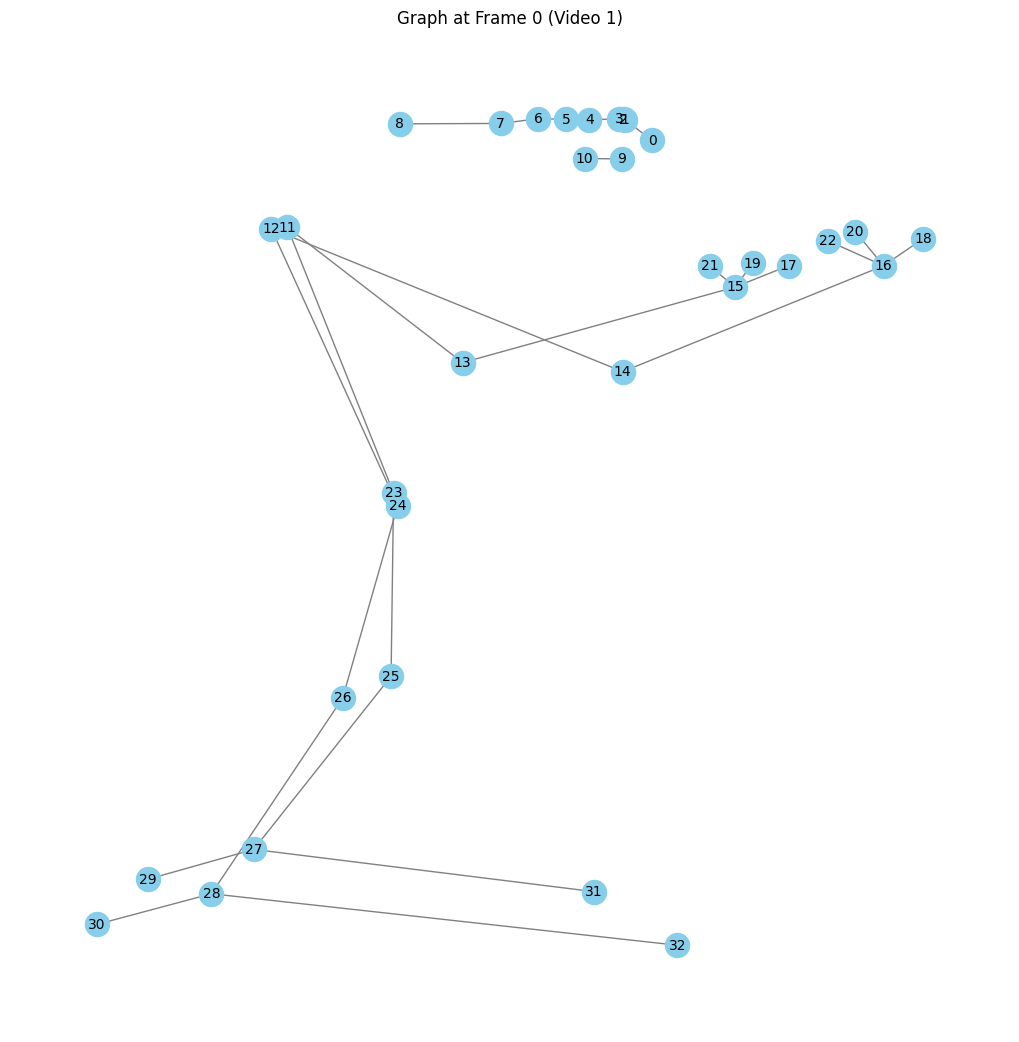

In [38]:
def draw_graph(graph, title="Graph Visualization"):
    pos = nx.get_node_attributes(graph, 'pos')
    
    # Invert y-coordinates
    inverted_pos = {node: (x, 1 - y) for node, (x, y) in pos.items()}
    
    plt.figure(figsize=(10, 10))
    nx.draw(graph, inverted_pos, with_labels=True, node_size=300, node_color='skyblue', edge_color='gray', font_size=10, font_color='black')
    plt.title(title)
    plt.show()

def visualize_graph_sequence(graphs, start=0, end=10):
    for i in range(start, end):
        draw_graph(graphs[i], title=f"Graph at Frame {i}")

# Example usage to visualize a single graph
draw_graph(graphs_video1[0], title="Graph at Frame 0 (Video 1)")

# Example usage to visualize a sequence of graphs
# visualize_graph_sequence(graphs_video1, start=0, end=5)

In [39]:
# save the graph
save_location_video1 = '/Users/suryanshpatel/Projects/Pose_detection/videos/Squats/correct_graph.pkl'
save_location_video2 = '/Users/suryanshpatel/Projects/Pose_detection/videos/Squats/incorrect_graph.pkl'

# Function to save graphs to a file
def save_graphs(graphs, filename):
    with open(filename, 'wb') as f:
        pickle.dump(graphs, f)

# Save the graphs for both videos
save_graphs(graphs_video1, save_location_video1)
save_graphs(graphs_video2, save_location_video2)
print('Videos saved success...')

Labling the exercise

In [2]:
import ssl
import certifi

# Set the SSL certificate location
ssl_context = ssl.create_default_context(cafile=certifi.where())


In [20]:
coordinates_video1.shape


(88, 33, 2)

In [21]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import torch.hub

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode

# Normalize coordinates to [0, 1]
coordinates_normalized = (coordinates_video1 - coordinates_video1.min()) / (coordinates_video1.max() - coordinates_video1.min())

# Convert to uint8 for image-like data
coordinates_uint8 = (coordinates_normalized * 255).astype(np.uint8)

# Prepare data tensor for inference
data_tensor = torch.tensor(coordinates_video1, dtype=torch.float32)
data_tensor = data_tensor.unsqueeze(0)  # Add batch dimension if necessary

# Perform inference
with torch.no_grad():
    outputs = model(data_tensor)

# Example: Get predicted class index (assuming classification task)
_, predicted = torch.max(outputs, 1)
predicted_label = predicted.item()

print(f"Predicted label index: {predicted_label}")


/Users/suryanshpatel/Projects/Pose_detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/suryanshpatel/Projects/Pose_detection/.venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 88, 33, 2] to have 3 channels, but got 88 channels instead

In [23]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np

# Assuming coordinates_video1 is your input data tensor with shape [88, 33, 2]

# Example: Convert coordinates_video1 to a 3-channel image-like tensor
# You should adjust this part based on how your data should be converted to an image format
# Here we are creating a dummy RGB-like image from the coordinates
# You should replace this with your actual preprocessing logic



# Normalize coordinates to [0, 1]
coordinates_normalized = (coordinates_video1 - coordinates_video1.min()) / (coordinates_video1.max() - coordinates_video1.min())

# Convert to uint8 for image-like data
coordinates_uint8 = (coordinates_normalized * 255).astype(np.uint8)

# Assuming coordinates_uint8 now has shape [88, 33, 3] representing RGB-like image
# Convert to PyTorch tensor and add batch dimension
data_tensor = torch.tensor(coordinates_uint8, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)

# Define torchvision transform to normalize the image data
# Adjust mean and std tensors to match the number of channels in data_tensor
mean = [0.5] * 2  # Example mean values for 2 channels
std = [0.5] * 2   # Example std values for 2 channels

transform = transforms.Compose([
    transforms.Normalize(mean=mean, std=std),
])

# Apply normalization transform
data_tensor = transform(data_tensor)

# Load pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)
model.eval()  # Set to evaluation mode

# Perform inference
with torch.no_grad():
    outputs = model(data_tensor)

# Example: Get predicted class index (assuming classification task)
_, predicted = torch.max(outputs, 1)
predicted_label = predicted.item()

print(f"Predicted label index: {predicted_label}")


RuntimeError: Given groups=1, weight of size [64, 3, 7, 7], expected input[1, 2, 88, 33] to have 3 channels, but got 2 channels instead